# Lumigator from Mozilla AI 🐊 🦊

Welcome to the Getting Started notebook for Lumigator, a powerful tool developed by
[Mozilla AI](https://www.mozilla.ai/) for evaluating language models. In this guide, we'll
walk you through the key features and functionalities of Lumigator, helping you quickly get
up to speed with using it for your LM evaluation tasks.

Specifically, we'll cover the following topics:

+ What Jupyter Notebooks are and how to use them.
+ An Overview of Machine Learning.
+ The Lumigator Platform 🐊
+ How do Machine Learning evaluation workflows look like.
+ The Thunderbird Ground Truth Dataset.
+ Selecting models to perform summarization:
  + Using one encoder/decoder (BART).
  + Utilizing two decoders (Mistral and GPT-4) to evaluate against ground truth.
+ Running evaluation experiments.
+ Discussing results.

## Jupyter Walkthrough

[Jupyter Notebooks](https://jupyter-notebook.readthedocs.io/en/stable/) provide an executable
environment for running (usually) Python code alongside text. To work with Jupyter, click the "play"
icon (i.e., ▶) to execute the code and view the results below the cell you are currently running.
You can also use the `shift + enter` shortcut to execute the code cell and move to the next one.
Cells are executed sequentially and can contain either text (Markdown) or Python code.

![cell-running](images/running.png)

Your files are located on the left-hand side. They'll be saved for the duration of our session, but
if you'd like to keep them, make sure to download them. 

![file-tree](images/files.png)

Lets' try running some code! Execute the following code and verify the output below.

In [1]:
print("Welcome to Lumigator!🐊")

Welcome to Lumigator!🐊


## Machine learning glossary

As we walk through this notebook, you’ll encounter several Machine Learning terms that are essential
to understanding the concepts and methods we'll be using. To help you follow along, we've compiled a
brief glossary of key terms you'll come across during the session:

+ **Machine learning**: The process of creating a model that learns from data.
+ **Dataset**: Data used to train models and evaluate their performance.
+ **LLM**: Large language model, [a text-based model that performs next-word predictions](https://www.nvidia.com/en-us/glossary/large-language-models/).
+ **Tokens**: Words broken up into pieces to be used in an LLM.
+ **Inference**: The process of getting a prediction from a large language model.
+ **Embeddings**: Numerical representations of text generated by modeling.
+ **Encoder-decoder models**: A neural network architecture comprised of two neural networks, an
  encoder that takes the input vectors from our data and creates an embedding of a fixed length, and
  a decoder, also a neural network, which takes the embeddings encoded as input and generates a
  static set of outputs such as translated text or a text summary.
+ **Decoder-only models** - Given a fixed input prompt, uses its representation to generate a
  sequence of words one at a time, with each word being conditioned on the ones generated
  previously.
+ **Task** - Machine learning tasks to fit a specific model type, including translation,
  summarization, completion, etc.
+ **Ground truth** - Information that has been evaluated to be true by humans (or LLMs, in some
  cases), that we can use to evaluate and compare trained models.

The process of **machine learning** is the process of creating a mathematical model that tries to
approximate the world. A **machine learning model** is a set of instructions for generating a given
output from data. The instructions are learned from the features of the input data itself.

Within the broad landscape of machine learning, there are various modeling approaches, including
**supervised**, **unsupervised**, and **reinforcement** learning. Each approach has its own set of
techniques and use cases.

In the context of language models, the kind of modeling we focus on with Large Language Models
(LLMs) primarily falls within the domain of neural network-based approaches. These models learn
patterns, structures, and relationships in data through vast networks of interconnected nodes (or
neurons), which allow them to generate, interpret, and manipulate natural language in powerful ways.

### How do LLMs work? 

There are many different kinds of LLMs and many different kinds of architectures. For our
evaluations, we use two different kinds:

+ **Encoder/Decoder** - BART is an encoder/decoder model that converts input data into a fixed-size
  representation (similar to encoder models). These models are trained first to transform text into
  numerical representations, then to output text based on those numerical representations. They're
  good for synthesis as opposed to generation. 
+ **Decoder-only** - most models in the GPT-family, like Mistral, GPT, and others we'll be working
  with, are pre-trained with text data in an autoregressive manner, for next-token prediction given
  previous tokens.  

### LLM Evaluation Workflows

The following steps outline the key phases involved in evaluating a Large Language Model (LLM):

1. **Generate Ground Truth**: The first step is to establish a reliable ground truth based on the
   specific business use case you're targeting. This represents the "correct" or expected output
   against which model performance will be measured.
1. **Select Models for Evaluation**: Next, choose several candidate models that you'd like to
   evaluate. These could be different versions of a language model, or distinct models altogether,
   depending on your evaluation criteria and use case.
1. **Run the Evaluation Loop**: This phase involves running the models through an evaluation process
   where you compare the model's outputs against the ground truth. You'll iterate through multiple
   examples, assessing how well each model performs in generating the desired results.
1. **Analyze Evaluation Results**: Finally, after completing the evaluation loop, you'll analyze the
   results to identify strengths, weaknesses, and areas for improvement. This analysis helps inform
   decisions about which model to use, optimize, or further train for the business use case at hand.

![lumigator-features](images/lumigator-features.svg)

On a technical level, Lumigator is a Python-based FastAPI web application designed to run services
that handle jobs and deployments on a Ray cluster. This cluster can be run either locally or in the
cloud, depending on your system's specifications and the resources available.

The results and job metadata generated during evaluations are stored in an SQL database for easy
tracking and retrieval. Additionally, larger models, which are often loaded from platforms like
[Hugging Face](https://huggingface.co/), require GPUs for efficient processing due to their size and
computational demands.

![lumigator-architecture](images/lumigator-architecture.svg)

What is Ray? [A distributed runtime for Python programs](https://github.com/ray-project/ray) that
includes a Core library with primitives (Tasks, Actors, and objects) and a suite of ML libraries
(Tune, Serve) that allow to build components of the Machine Learning model workflow. 

### Nota bene: Machine Learning is alchemy

When we think of traditional software application workflows, we think of an example such as adding a
button. We can clearly test that we've added a blue button to our application, and that it works
correctly. Machine Learning is not like this! It involves a lot of experimentation, tweaking of
hyperparameters and prompts and trying different models. Expect for the process to be imperfect,
with many iterative loops. Luckily, Lumigator helps take away the uncertainty of at least model
selection. 🙂

> There’s a self-congratulatory feeling in the air. We say things like “Machine Learning is the new
> electricity”. I’d like to offer an alternative metaphor: Machine Learning has become alchemy. -
> [Ben Recht and Ali Rahimi](https://archives.argmin.net/2017/12/05/kitchen-sinks/)

Ultimately, the final conclusion of whether a model is good is if humans think it's good. With that
in mind, let's dive into setting up experiments with Lumigator to test our models!

## Importing Required Libraries

Before we begin working with Lumigator, we'll need to import several libraries and modules that
provide the necessary functionality for our tasks. In this section, we'll load the core
dependencies, including tools for data handling, and visualization.

In [2]:
# Importing packages we need to work with data
# python standard libraries
import os

# Random string generator
import matplotlib.pyplot as plt

# third-party libraries
import pandas as pd
from datasets import load_dataset
from lumigator_schemas.datasets import DatasetFormat
from lumigator_sdk.lumigator import LumigatorClient
from lumigator_sdk.strict_schemas import JobCreate, JobEvalConfig, JobInferenceConfig
from utils import get_nested_value, job_result_download, results_to_table

# wrap columns for inspection
pd.set_option("display.max_colwidth", 0)
# stylesheet for visibility
plt.style.use("fast")

%load_ext autoreload
%autoreload 2

In [3]:
LUMIGATOR_SERVICE_HOST = os.getenv("LUMIGATOR_SERVICE_HOST", "localhost")
LUMIGATOR_SERVICE_PORT = os.getenv("LUMIGATOR_SERVICE_PORT", "8000")

# Understanding the Lumigator App and API 

The app itself consists of an API, which you can access and test out methods in the
[OpenAPI spec](https://swagger.io/specification/), at the platform URL, under docs.

If you are running Lumigator as a local installation, you can directly access the API at
[this URL](http://localhost:8000/docs).

![lumigator-api](images/lumigator-api.png)

Large language models today are consumed in one of several ways:

+ As **API endpoints** for proprietary models hosted by [OpenAI](https://openai.com/),
  [Anthropic](https://www.anthropic.com/), or major cloud providers.
+ As **model artifacts** downloaded from HuggingFace’s Model Hub, trained/fine-tuned using
  HuggingFace libraries, and hosted on local storage.
+ As model artifacts available in a format optimized for **local inference**, typically
  [GGUF](https://github.com/ggerganov/ggml/blob/master/docs/gguf.md), and accessed via applications
  like [llama.cpp](https://github.com/ggerganov/llama.cpp) or [ollama](https://ollama.com/).
+ As [ONNX](https://onnx.ai/), a format which optimizes sharing between backend ML frameworks.

We use API endpoints and local storage in Lumigator. We currently have four key endpoints on the
platform:

+ `/health`: Status of the application, running status of jobs and deployments. 
+ `/datasets`: Data that we add to the platform for evaluation. We can upload, delete, and save
  different data in the platform. We'll use this to also save our ground truth and experiment data.
+ `/jobs`: Our actual jobs. We can list all previous jobs, create new ones, and
  get their results. This includes evaluation as well as inference access to external APIs such as Mistral and OpenAI.

## Model Task: Summarization

The task we'll be working with is *summarization*, aka we want to generate a summary of our text. In
our business case, which is to create summaries of conversation threads, much as you might see in
Slack or an email chain, the models need to be able to extract key information from those threads
while still being able to accept a large context window to capture the entire conversation history. 

We identified that it is far more valuable to conduct *abstractive* summaries—summaries that
identify important sections in the text and generate highlights—rather than *extractive* ones, which
select a subset of sentences and staple them together. This is because the final interface will be
in natural language, and we want to avoid summaries that are interpreted from often incoherent text
snippets produced by extractive methods.

For more on summarization as a use-case, [see our blog post here.](https://blog.mozilla.ai/on-model-selection-for-text-summarization/)

## Ground Truth for Models

The term ground truth comes from geology and geospatial sciences, where actual information was
collected on the ground to validate data acquired through remote sensing, such as satellite imagery
or aerial photography. Since then, the concept has been adopted in other fields, particularly in
machine learning and artificial intelligence, to refer to the accurate, real-world data used for
training and testing models. 

The **best ground truth is human-generated** but building it is a very expensive task. One recent
trend is to rely on large language models but they have their own pitfalls. An intermediate approach
uses different LLMs to provide ground truth "candidates" which are then subject to human pairwise
evaluation.

## Our Input data

The data we'll be using in this walkthrough comes from
[DialogSum](https://github.com/cylnlp/DialogSum), a large-scale labeled dialogue summarization
dataset which comes with ground truth provided by human annotators. Here follows a brief description
of DialogSum.

In [4]:
# The dataset is available at https://huggingface.co/datasets/knkarthick/dialogsum
# and can be directly downloaded with the `load_dataset` method
dataset = "knkarthick/dialogsum"
ds = load_dataset(dataset, split="validation")
df = ds.to_pandas()  # noqa: PD901

Generating train split:   0%|          | 0/12460 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [5]:
# Examine a single sample
df["dialogue"].iloc[0]

"#Person1#: Hello, how are you doing today?\n#Person2#: I ' Ve been having trouble breathing lately.\n#Person1#: Have you had any type of cold lately?\n#Person2#: No, I haven ' t had a cold. I just have a heavy feeling in my chest when I try to breathe.\n#Person1#: Do you have any allergies that you know of?\n#Person2#: No, I don ' t have any allergies that I know of.\n#Person1#: Does this happen all the time or mostly when you are active?\n#Person2#: It happens a lot when I work out.\n#Person1#: I am going to send you to a pulmonary specialist who can run tests on you for asthma.\n#Person2#: Thank you for your help, doctor."

In [6]:
# Add a function to do some simple character counts for model input
df["char_count"] = df["dialogue"].str.len()

In [7]:
# inspect our data
df.head(n=3)

,id,dialogue,summary,topic,char_count
0,dev_0,"#Person1#: Hello, how are you doing today?\n#Person2#: I ' Ve been having trouble breathing lately.\n#Person1#: Have you had any type of cold lately?\n#Person2#: No, I haven ' t had a cold. I just have a heavy feeling in my chest when I try to breathe.\n#Person1#: Do you have any allergies that you know of?\n#Person2#: No, I don ' t have any allergies that I know of.\n#Person1#: Does this happen all the time or mostly when you are active?\n#Person2#: It happens a lot when I work out.\n#Person1#: I am going to send you to a pulmonary specialist who can run tests on you for asthma.\n#Person2#: Thank you for your help, doctor.",#Person2# has trouble breathing. The doctor asks #Person2# about it and will send #Person2# to a pulmonary specialist.,see a doctor,622
1,dev_1,"#Person1#: Hey Jimmy. Let's go workout later today.\n#Person2#: Sure. What time do you want to go?\n#Person1#: How about at 3:30?\n#Person2#: That sounds good. Today we work on Legs and forearm.\n#Person1#: Hey. I just played basketball earlier, so my legs are a little sore. Let's work out on arms and stomach today.\n#Person2#: I'm on a weekly schedule. You're messing everything up.\n#Person1#: C'mon. We're only switching two days. You can do legs on Friday.\n#Person2#: Aright. I'll meet you at the gym at 3:30 then.",#Person1# invites Jimmy to go workout and persuades him into working out on arms and stomach.,do exercise,514
2,dev_2,"#Person1#: I need to stop eating such unhealthy foods.\n#Person2#: I know what you mean. I've started eating better myself.\n#Person1#: What foods do you eat now?\n#Person2#: I tend to stick to fruits, vegetables, and chicken.\n#Person1#: Those are the only things you eat?\n#Person2#: That's basically what I eat.\n#Person1#: Why aren't you eating anything else?\n#Person2#: Well, fruits and vegetables are very healthy.\n#Person1#: And the chicken?\n#Person2#: It's really healthy to eat when you bake it.\n#Person1#: I guess that does sound a lot healthier.","#Person1# plans to stop eating unhealthy foods, and #Person2# shares #Person2#'s healthy recipe with #Person1#.",healthy foods,550


In [8]:
# Show statistics about characters count
df["char_count"].describe()

count    500.000000 
mean     727.386000 
std      366.971931 
min      211.000000 
25%      477.000000 
50%      642.500000 
75%      912.500000 
max      2563.000000
Name: char_count, dtype: float64

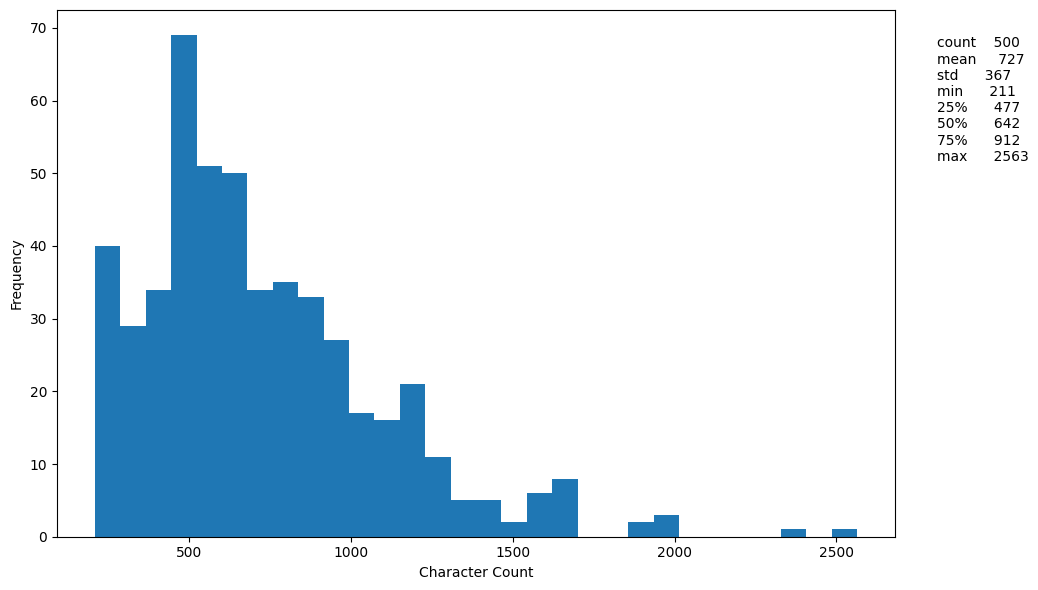

In [9]:
# Generate plot of character counts
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(df["char_count"], bins=30)
ax.set_xlabel("Character Count")
ax.set_ylabel("Frequency")

stats = df["char_count"].describe().apply(lambda x: f"{x:.0f}")

# Add text boxes for statistics
plt.text(1.05, 0.95, stats.to_string(), transform=ax.transAxes, verticalalignment="top")

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(right=0.75)

plt.show()

## Save and upload datasets

Now that you have seen how the option to generate ground truth works, let us save all datasets and
make them available to lumigator for further experiments. For each example (i.e., dialogsum original
dataset) we will perform the following operations:

1. Make sure that the two main fields (original text and ground truth) are called `examples` and
  `ground_truth`, which are the names internally used by Lumigator to refer to them, and save the
  datasets as CSV files.
2. Make the dataset available to Lumigator with the `create_dataset` method.

In [10]:
ds = ds.remove_columns(["id", "topic"])
ds = ds.rename_column("dialogue", "examples")
ds = ds.rename_column("summary", "ground_truth")

dataset_name = "dialogsum_converted.csv"
ds.to_csv(dataset_name)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

430961

In [11]:
from pathlib import Path

lm_client = LumigatorClient(f"{LUMIGATOR_SERVICE_HOST}:{LUMIGATOR_SERVICE_PORT}")

loaded_dataset = lm_client.datasets.create_dataset(Path.open(dataset_name, "rb"), DatasetFormat.JOB)

In [12]:
# And let's check that data loaded
datasets = lm_client.datasets.get_datasets()

## Jobs

After generating the ground truth (either manually or with the aid of some models) and uploading the
dataset to lumigator, we are ready to start evaluating models on it. Note that when you uploaded
your datasets you got back some information that included a dataset `id`. This is a unique
identifier to your own dataset that you can reuse across different jobs.

In [13]:
dataset = loaded_dataset

# now look for the dataset on lumigator
result = lm_client.datasets.get_dataset(dataset.id)
dataset_id, dataset_name = result.id, result.filename
print(f"Annotated dataset: {dataset_id, dataset_name}")

Annotated dataset: (UUID('d1d196ce-6a0f-4d7b-8f56-7f1e6ee633df'), 'dialogsum_converted.csv')


### Model Selection

What you see below are different lists of models we have already tested for the summarization task.
The `models` variable at the end provides you with a selection, but you can choose any combination
of them: the default is a single local model (`facebook/bart-large-cnn`), but depending on your
setup you can choose more and/or add different APIs.

Note that different model types are specified with different prefixes:

- `hf` is used for HuggingFace models which are downloaded and ran as Ray jobs.
- `mistral/` is used for models which are accessed through the Mistral API.
- `gpt-4` is specified directly per the [LiteLLM api](https://docs.litellm.ai/docs/providers/openai)

In [ ]:
# Here follows a list of models we have tested for summarization:
# feel free to add any of them in the "models" list below
#
# Encoder-Decoder models
#    'facebook/bart-large-cnn',
#    'Falconsai/text_summarization',
#
# Decoder models
#    'mistral/open-mistral-7b',
#
# GPTs
#    "gpt-4o-mini",
#    "gpt-4-turbo",
#    "gpt-3.5-turbo-0125",
#
models = [
    "facebook/bart-large-cnn",
]

### Run Evaluations

The following cell will start the actual model evaluations. Once you run it, new jobs will be
submitted to ray (one for each model) and the outcomes of these submissions will be printed.

Each evaluation job will first use the provided model to summarize each of the emails in the input
dataset. After that, it will calculate a few metrics to evaluate how close the predicted summaries
are to the ground truth provided in the dataset. Each job starts with a `created` status. While the
job runs, you will be able to track its status by running the cell in the next section.

In [15]:
# set this value to limit the evaluation to the first max_samples items (0=all)
max_samples = 10
# team_name is a way to group jobs together under the same namespace, feel free to customize it
team_name = "lumigator_enthusiasts"

responses = []
for model in models:
    infer_job_config = JobInferenceConfig(
        model=model,
        provider="hf",
        output_field="predictions",
        store_to_dataset=True,
    )
    infer_job_create = JobCreate(
        name=f"{team_name}: Summary inference for model {model}",
        description="Test run (inference)",
        dataset=dataset_id,
        max_samples=max_samples,
        job_config=infer_job_config,
    )
    job_infer_creation_result = lm_client.jobs.create_job(infer_job_create)
    lm_client.jobs.wait_for_job(job_infer_creation_result.id)

    infer_dataset = lm_client.jobs.get_job_dataset(str(job_infer_creation_result.id))

    eval_job_config = JobEvalConfig(
        metrics=["rouge", "meteor", "bertscore"],
    )
    eval_job_create = JobCreate(
        name=f"{team_name}: Summary evaluation for model {model}",
        description="Test run (evaluation)",
        dataset=str(infer_dataset.id),
        job_config=eval_job_config,
    )

    job_eval_creation_result = lm_client.jobs.create_job(eval_job_create)
    responses.append(job_eval_creation_result)

2025-02-19 12:04:44.529 | INFO     | lumigator_sdk.client:_make_request:76 - {
  "type": "SUBMISSION",
  "job_id": null,
  "submission_id": "3ce83fb1-e1df-4b39-b608-06b6d6ab9be3",
  "driver_info": null,
  "status": "PENDING",
  "entrypoint": "python inference.py --config '{\"name\":\"lumigator_enthusiasts: Summary inference for model facebook/bart-large-cnn/3ce83fb1-e1df-4b39-b608-06b6d6ab9be3\",\"dataset\":{\"path\":\"s3://lumigator-storage/datasets/d1d196ce-6a0f-4d7b-8f56-7f1e6ee633df/dialogsum_converted.csv\"},\"job\":{\"max_samples\":10,\"storage_path\":\"s3://lumigator-storage/jobs/results/\",\"output_field\":\"predictions\"},\"hf_pipeline\":{\"model_name_or_path\":\"facebook/bart-large-cnn\",\"revision\":\"main\",\"use_fast\":true,\"trust_remote_code\":false,\"torch_dtype\":\"auto\",\"accelerator\":\"auto\",\"max_new_tokens\":500,\"task\":\"summarization\"}}'",
  "message": "Job has not started yet. It may be waiting for the runtime environment to be set up.",
  "error_type": nul

![ray-job](images/ray-job.png)

### Track Evaluation Jobs

To track the progress of your evaluation jobs, you’ll need to run the following commands. These jobs
are executed on a Ray cluster, which efficiently distributes the workload across multiple nodes,
whether locally or in the cloud.

Not that you won't be able to run other cells while this one is running. However, you can interrupt
it whenever you want by clicking on the "stop" button above and run it at a later time.

In [16]:
for response in responses:
    job_id = response.id
    job = lm_client.jobs.wait_for_job(job_id)
    print(job)

2025-02-19 12:06:45.745 | INFO     | lumigator_sdk.client:_make_request:76 - {
  "type": "SUBMISSION",
  "job_id": null,
  "submission_id": "4ecacfcd-08d3-4fb7-8bea-f595fc834be8",
  "driver_info": null,
  "status": "PENDING",
  "entrypoint": "python evaluator.py --config '{\"name\":\"lumigator_enthusiasts: Summary evaluation for model facebook/bart-large-cnn/4ecacfcd-08d3-4fb7-8bea-f595fc834be8\",\"dataset\":{\"path\":\"s3://lumigator-storage/datasets/f1f4506f-18af-4f08-af24-2cb135d7dbc5/dialogsum_converted-annotated.csv\"},\"evaluation\":{\"metrics\":[\"rouge\",\"meteor\",\"bertscore\"],\"max_samples\":-1,\"return_input_data\":true,\"return_predictions\":true,\"storage_path\":\"s3://lumigator-storage/jobs/results/\"}}'",
  "message": "Job has not started yet. It may be waiting for the runtime environment to be set up.",
  "error_type": null,
  "start_time": 1739984805707,
  "end_time": null,
  "metadata": {
    "job_type": "evaluator"
  },
  "runtime_env": {
    "working_dir": "gcs://

{'type': 'SUBMISSION', 'job_id': None, 'submission_id': '4ecacfcd-08d3-4fb7-8bea-f595fc834be8', 'driver_info': None, 'status': 'SUCCEEDED', 'entrypoint': 'python evaluator.py --config \'{"name":"lumigator_enthusiasts: Summary evaluation for model facebook/bart-large-cnn/4ecacfcd-08d3-4fb7-8bea-f595fc834be8","dataset":{"path":"s3://lumigator-storage/datasets/f1f4506f-18af-4f08-af24-2cb135d7dbc5/dialogsum_converted-annotated.csv"},"evaluation":{"metrics":["rouge","meteor","bertscore"],"max_samples":-1,"return_input_data":true,"return_predictions":true,"storage_path":"s3://lumigator-storage/jobs/results/"}}\'', 'message': 'Job finished successfully.', 'error_type': None, 'start_time': 1739984805707, 'end_time': 1739984822521, 'metadata': {'job_type': 'evaluator'}, 'runtime_env': {'working_dir': 'gcs://_ray_pkg_62b784a797c06670.zip', 'pip': {'packages': ['absl-py==2.1.0', 'bert_score==0.3.13', 'click>=8.1.7', 'datasets==2.20.0', 'evaluate==0.4.3', 'loguru==0.7.2', 'nltk==3.8.1', 'numpy<2.0

## Show evaluation results

Once all evaluations are completed, their results will be stored on our platform and available for
download. The following cell iterates on all your job ids, downloads results from each, and builds a
table comparing different metrics for each model.

The metrics we use to evaluate are ROUGE, METEOR, and BERT score. They all measure similarity
between predicted summaries and those provided with the ground truth, but each of them focuses on
different aspects. The image below shows their main characteristics and the tradeoffs between their
flexibility and their computational cost.

![metrics](images/metrics.png)

In [17]:
job_id = responses[0].id
job_download = lm_client.jobs.get_job_download(job_id)
result = job_result_download(job_download)
print(result)
model_name = models[0]
result["artifacts"]["model"] = model_name

{'metrics': {'bertscore': {'precision': [0.8868253231048584, 0.8602862358093262, 0.8505913615226746, 0.8509877920150757, 0.8750339150428772, 0.874916672706604, 0.8061472177505493, 0.8783702850341797, 0.8522675037384033, 0.8597515821456909], 'recall': [0.877102255821228, 0.8969284296035767, 0.8292868137359619, 0.8026381731033325, 0.9205142259597778, 0.8589411973953247, 0.8951081037521362, 0.8766474723815918, 0.8470866680145264, 0.8712852001190186], 'f1': [0.8819370269775391, 0.8782253265380859, 0.83980393409729, 0.8261061906814575, 0.8971980810165405, 0.8668553233146667, 0.8483017086982727, 0.8775080442428589, 0.8496692180633545, 0.8654799461364746], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.48.0)', 'precision_mean': 0.8595177888870239, 'recall_mean': 0.8675538539886475, 'f1_mean': 0.8631084799766541}, 'meteor': {'meteor': [0.32206632653061223, 0.3571120689655172, 0.2662037037037037, 0.13201767990074442, 0.647170290027433, 0.149812734082397, 0.36757662835249044, 0

In [18]:
results_to_table([(result, model_name)])

,Model,Meteor,BERT Precision,BERT Recall,BERT F1,ROUGE-1,ROUGE-2,ROUGE-L,RAM_GB
0,facebook/bart-large-cnn,0.323741,0.859518,0.867554,0.863108,0.268168,0.126223,0.207715,2.71


## Analysis of Evaluation Results

The table above is just a summary of all the evaluation results. The `result` object contains way
more details from which you'll be able to get a few more insights in the following cells.

The following cell shows you the kind of information that's available in each of the `result` object
elements. This information is nested at different depth levels. You can access each using the
`get_nested_value` command.

In [19]:
# eval_results is a list holding information for each of the models you defined before
# for each element, you can access different metrics, time performance, and predictions
result.keys()

dict_keys(['metrics', 'parameters', 'artifacts'])

In [20]:
# see how much time it took for a model to summarize all the input samples
get_nested_value(result, "inference_time")

In [21]:
# see all the bertscore data
get_nested_value(result, "bertscore")

In [22]:
# see mean bert precision
get_nested_value(result, "bertscore/precision_mean")